In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

# Определение возраста покупателей

Задача.
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.
Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

План работы
- Провести анализ предоставленных данных с оценкой достаточности данных и их распределения для обучения модели
- Подготовить данные к обучению с оценкой необходимости проведения аугментации
- Выбрать сеть и провести ее обучение с проверкой результативности метрикой МАЕ

## Исследовательский анализ данных

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) # < Перенесите сюда исследовательский анализ данных >

Found 7591 validated image filenames.


In [3]:
# Смотрим общую информацию о таблице
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
# Смотрим общие статистические данные
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Text(0, 0.5, 'Количество')

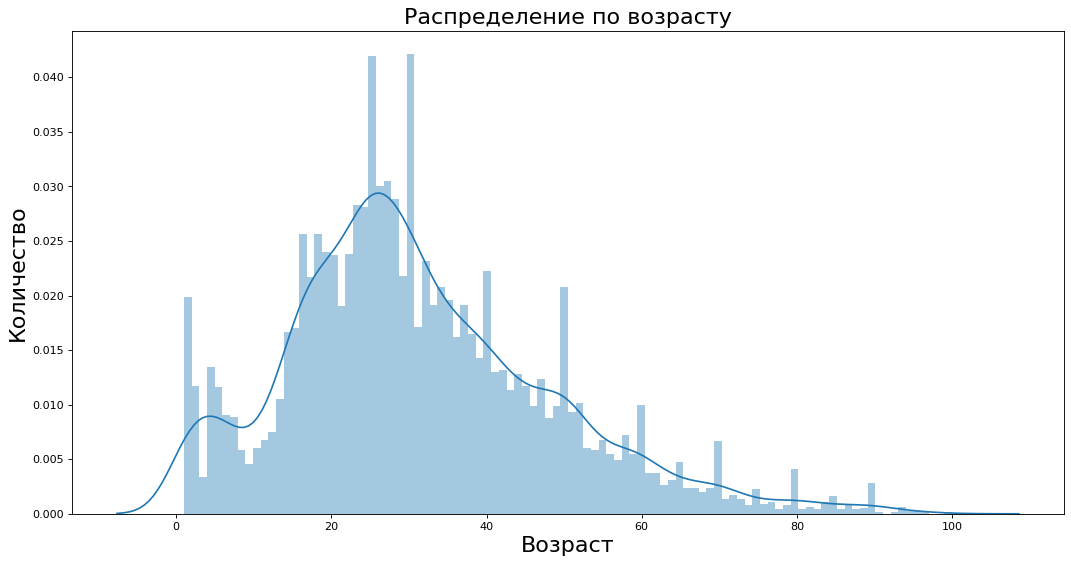

In [5]:
# Смотрим распределение по возрасту
plt.figure(figsize=(16,8), dpi=80)

sns.distplot(labels['real_age'],  hist = True, bins=100)
plt.title("Распределение по возрасту", fontsize=20)
plt.xlabel("Возраст", fontsize=20)
plt.ylabel("Количество", fontsize=20)


Text(0.5, 0, 'Возраст')

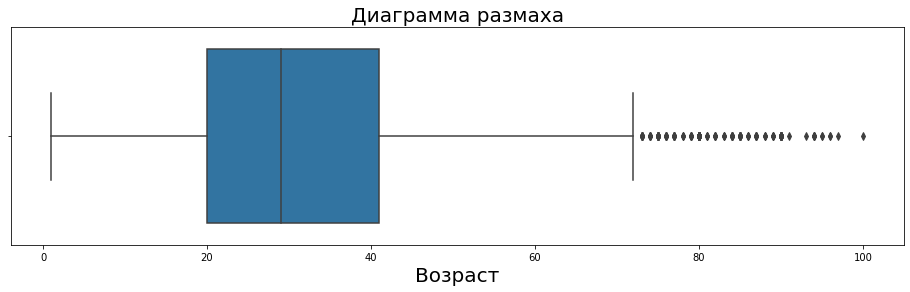

In [6]:
# Потроим для возраста диаграмму размаха
plt.figure(figsize=(16,4))
sns.boxplot(labels['real_age'])
plt.title("Диаграмма размаха", fontsize=20)
plt.xlabel("Возраст", fontsize=20)

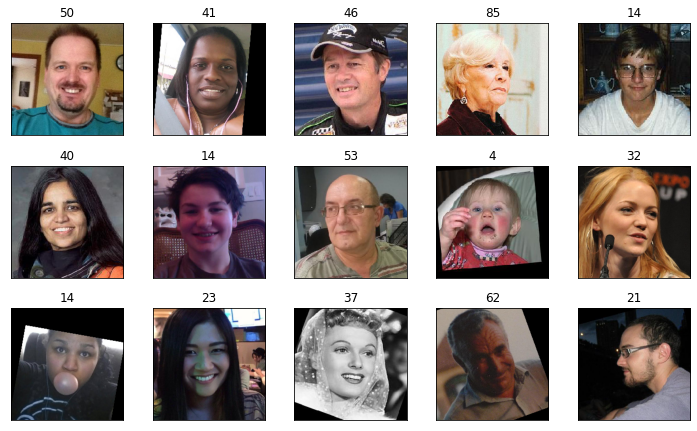

In [7]:
# Получение следующего батча
features, target = next(train_gen_flow)

# Выведем фотографии
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([]) 
    plt.yticks([])
    plt.tight_layout()

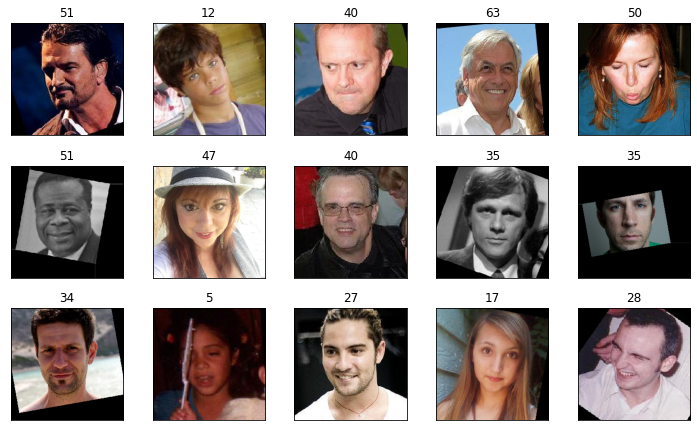

In [8]:
# Получение следующего батча
features, target = next(train_gen_flow)

# Выведем фотографии
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([]) 
    plt.yticks([])
    plt.tight_layout()

### Выводы

- В представленных данных содержатся: - цветные и черно-белые фотографии,
                                      - фотографии со смещением и поворотом,
                                      - фотографии других размеров,
                                      - часть фотографий имеет незначительный поворот, 
                                      - в целом фотографии имеют правильную ориентацию и поворачивать их не нужно
- Диаграмма распределение по возрасту имеет 2 всплеска, причем первый из них приходится на детей возрастом ~ 5 лет, второй на медианное значение - 29 лет  
- Наличие "всплесков" на возрастах 30, 40, 50 и т.д. может говорить о том, что при создании выборки данные по возрасту округлялись 
- Распределение по возрасту смещено в сторону молодых людей, возрастом до ~ 35 лет

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import numpy as np
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
     
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = pd.read_csv(path+'labels.csv'),
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(256, 256),
        batch_size=32,
        class_mode='raw',
        subset='training',
        horizontal_flip=True,
        seed=12345)
    return train_datagen_flow

def load_test(path):
    
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = pd.read_csv(path+'labels.csv'),
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(256, 256),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet',
                    include_top= False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model


```

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
2022-06-18 09:28:05.350072: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-18 09:28:07.632024: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 66s - loss: 257.9535 - mae: 11.4024 - val_loss: 1036.9107 - val_mae: 27.5427
Epoch 2/10
178/178 - 38s - loss: 64.8769 - mae: 6.0909 - val_loss: 693.7965 - val_mae: 21.1643
Epoch 3/10
178/178 - 38s - loss: 30.8155 - mae: 4.2595 - val_loss: 309.4239 - val_mae: 12.9702
Epoch 4/10
178/178 - 37s - loss: 19.3666 - mae: 3.4084 - val_loss: 128.8747 - val_mae: 8.5946
Epoch 5/10
178/178 - 37s - loss: 15.2215 - mae: 3.0293 - val_loss: 76.8872 - val_mae: 6.6289
Epoch 6/10
178/178 - 37s - loss: 13.2616 - mae: 2.8369 - val_loss: 73.8517 - val_mae: 6.6746
Epoch 7/10
178/178 - 38s - loss: 11.5239 - mae: 2.6257 - val_loss: 73.1793 - val_mae: 6.3153
Epoch 8/10
178/178 - 38s - loss: 9.6551 - mae: 2.3895 - val_loss: 71.1436 - val_mae: 6.4748
Epoch 9/10
178/178 - 38s - loss: 8.8612 - mae: 2.2475 - val_loss: 75.3690 - val_mae: 6.7587
Epoch 10/10
178/178 - 38s - loss: 8.1978 - mae: 2.1556 - val_loss: 69.9955 - val_mae: 6.2414


```

```python

import numpy as np
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
     
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25, horizontal_flip=True)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = pd.read_csv(path+'labels.csv'),
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow

def load_test(path):
    
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = pd.read_csv(path+'labels.csv'),
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet',
                    include_top= False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
2022-06-19 16:58:15.698692: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-19 16:58:16.435665: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 91s - loss: 228.9954 - mae: 10.9854 - val_loss: 1005.1079 - val_mae: 27.0069
Epoch 2/10
178/178 - 38s - loss: 75.7103 - mae: 6.5315 - val_loss: 830.5899 - val_mae: 23.8794
Epoch 3/10
178/178 - 38s - loss: 48.3440 - mae: 5.2746 - val_loss: 285.1346 - val_mae: 12.4752
Epoch 4/10
178/178 - 37s - loss: 34.2199 - mae: 4.4591 - val_loss: 125.4172 - val_mae: 8.4187
Epoch 5/10
178/178 - 38s - loss: 28.4315 - mae: 4.0619 - val_loss: 87.0616 - val_mae: 7.0203
Epoch 6/10
178/178 - 38s - loss: 21.8565 - mae: 3.5893 - val_loss: 69.1881 - val_mae: 6.2011
Epoch 7/10
178/178 - 37s - loss: 18.4740 - mae: 3.2948 - val_loss: 81.8005 - val_mae: 6.9760
Epoch 8/10
178/178 - 38s - loss: 15.7649 - mae: 3.0599 - val_loss: 65.3998 - val_mae: 5.9397
Epoch 9/10
178/178 - 38s - loss: 12.9179 - mae: 2.7152 - val_loss: 71.1234 - val_mae: 6.4502
Epoch 10/10
178/178 - 38s - loss: 11.2488 - mae: 2.5684 - val_loss: 64.7620 - val_mae: 6.0491
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 64.7620 - mae: 6.0491
Test MAE: 6.0491

## Анализ обученной модели

При подготовке данных использовалась аугментация с отражением по горизонтали.

Для обучения применялась нейронная сеть ResNet50 без верхушки.
С добавлением глобального двумерного пулинга усреднением и полносвязного слоя 

При подготовке модели к обучению - для градиентного спуска был применен алгоритм Adam с шагом градиентного спуска 0.0001.

- Показатель МАЕ на валидационной выборке составил 6,24, при необходимом не менее 8. 
- Начиная с 5 эпохи изменение показателя МАЕ незначительно

Полученная модель в целом позволяет решать поставленные задачи, однако для ее улучшения стоит добавить в обучающий датафрейм: - данные с людьми старше 70 лет,
           - данные с детьми от 5 до 15 лет
